In [50]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
from sklearn.preprocessing import scale as scaler
from sklearn.model_selection import KFold
import numpy.random as npr
import robust_loss_pytorch
from robust_loss_pytorch import distribution
import robust_loss_pytorch.general as general
import random
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)

In [51]:
def train_regular(model, trX, trY, dist, learning_rate=0.01, epoch=500, verbose=True):

    params = list(model.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(dist.loss(y_hat, trY))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            # You can see the alpha+scale parameters moving around.
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model


def train_adaptive(model, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
        num_dims=1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
    params = list(model.parameters()) + list(adaptive.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        loss = torch.mean(adaptive.lossfun((y_hat - trY)[:,None]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            e, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data))
    return model, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data


def train_locally_adaptive(model, alpha, scale, trX, trY, learning_rate=0.01, epoch=500, verbose=True):
    params = list(model.parameters()) + list(alpha.parameters()) + list(scale.parameters())
    dist = distribution.Distribution()
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    for e in tqdm(range(epoch)):
        y_hat = model(trX).view(-1)
        alphas = torch.exp(alpha(trX))
        scales = torch.exp(scale(trX))
        loss = general.lossfun((y_hat - trY)[:, None], alpha=alphas, scale=scales, approximate=False)
        log_partition = torch.log(scales) + dist.log_base_partition_function(alphas)
        loss = (loss + log_partition).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and np.mod(e, 100) == 0:
            print('{:<4}: loss={:03f}'.format(e, loss.data))
    return model, alpha, scale


class PolyRegression(nn.Module):
    def __init__(self, dim, init_zeros=False):
        super(PolyRegression, self).__init__()
        self.beta = nn.Linear(dim, 1)
        self.n_poly = dim
        if init_zeros:
            with torch.no_grad():
                self.beta.weight.copy_(torch.zeros(dim))
                self.beta.bias.copy_(torch.zeros(1))

    def forward(self, x):
        """
        x: N x dim
        """
        expand = [(x**(i+1)).view(-1, 1) for i in range(self.n_poly)]
        expand = torch.cat(expand, dim=1)
        return self.beta(expand)


class AdaptiveRegression(nn.Module):
    def __init__(self):
        pass

    def forward(self, x):
        pass

In [52]:
class Gaussian(object):
    def loss(self, x, y):
        return (x-y)**2

    def loglikelihood(self, res, sigma=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if sigma is None:
            sigma = np.mean(res**2)
        N = len(res)
        ll = -N/2*np.log(2*np.pi*sigma) - 1/(2*sigma)*np.sum(res**2)
        return ll


class Laplace(object):
    def loss(self, x, y):
        return torch.abs(x-y)

    def loglikelihood(self, res, b=None):
        """
        calculate log likelihood of residuals
        :param res:
        :return:
        """
        # sample variance
        if b is None:
            b = np.sqrt(np.mean(res ** 2)/2)
        N = len(res)
        ll = -N*np.log(2*b) - 1/b*np.sum(np.abs(res))
        return ll


class Adaptive(object):
    def loglikelihood(self, res, alpha, scale):
        assert alpha.view(-1).size()[0] == 1 or alpha.view(-1).size()[0] == len(res)
        N = len(res)
        dist = distribution.Distribution()
        loss = general.lossfun(res, alpha, scale, approximate=False).sum()
        log_partition = torch.log(scale) + dist.log_base_partition_function(alpha)
        if alpha.view(-1).size()[0] == 1:
            log_partition = N*log_partition
        else:
            log_partition = log_partition.sum()
        nll = loss + log_partition
        return -nll.detach().numpy()

    def sample(self, alpha, c):
        alpha = torch.as_tensor(alpha)
        scale = torch.as_tensor(c)
        assert (alpha >= 0).all()
        assert (scale >= 0).all()
        float_dtype = alpha.dtype
        assert scale.dtype == float_dtype

        cauchy = torch.distributions.cauchy.Cauchy(0., np.sqrt(2.))
        uniform = torch.distributions.uniform.Uniform(0, 1)
        samples = torch.zeros_like(alpha)
        accepted = torch.zeros(alpha.shape).type(torch.bool)
        dist = distribution.Distribution()
        while not accepted.type(torch.uint8).all():
            # Draw N samples from a Cauchy, our proposal distribution.
            cauchy_sample = torch.reshape(
              cauchy.sample((np.prod(alpha.shape),)), alpha.shape)
            cauchy_sample = cauchy_sample.type(alpha.dtype)

            # Compute the likelihood of each sample under its target distribution.
            nll = dist.nllfun(cauchy_sample,
                            torch.as_tensor(alpha).to(cauchy_sample),
                            torch.tensor(1).to(cauchy_sample))

            # Bound the NLL. We don't use the approximate loss as it may cause
            # unpredictable behavior in the context of sampling.
            nll_bound = general.lossfun(
              cauchy_sample,
              torch.tensor(0., dtype=cauchy_sample.dtype),
              torch.tensor(1., dtype=cauchy_sample.dtype),
              approximate=False) + dist.log_base_partition_function(alpha)

            # Draw N samples from a uniform distribution, and use each uniform sample
            # to decide whether or not to accept each proposal sample.
            uniform_sample = torch.reshape(
              uniform.sample((np.prod(alpha.shape),)), alpha.shape)
            uniform_sample = uniform_sample.type(alpha.dtype)
            accept = uniform_sample <= torch.exp(nll_bound - nll)

            # If a sample is accepted, replace its element in `samples` with the
            # proposal sample, and set its bit in `accepted` to True.
            samples = torch.where(accept, cauchy_sample, samples)
            accepted = accepted | accept

            # Because our distribution is a location-scale family, we sample from
            # p(x | 0, \alpha, 1) and then scale each sample by `scale`.
            samples *= scale
        return samples

In [53]:
class ModalLinearRegression(object):
    def __init__(self, kernel='gaussian', bandwidth=1, maxitr=100, poly=1):
        """
        :param w_dim: dimension of input covariates
        :param kernel: type of kernel
        :param bandwidth: bandwidth for kernel
        """
        self.kernel_type = kernel
        self.bandwidth = bandwidth
        self.maxitr = maxitr
        self.coef_ = None
        self.intercept_ = None
        self.poly = poly

    def kernel(self, x, y):
        assert self.kernel_type in {'gaussian', 'linear', 'exponential'}, "Invalid Kernel"
        if self.kernel_type == 'gaussian':
            return np.exp(-((y-x)/self.bandwidth)**2)
        if self.kernel_type == 'linear':
            return 0 if (y-x) > self.bandwidth else 1-(y-x)/self.bandwidth

    def fit(self, x, y):
        n, dim = x.shape
        x = np.hstack([x**(i+1) for i in range(self.poly)])
        X = np.hstack([x, np.ones(n).reshape(-1, 1)])  # insert bias
        w = np.zeros([self.poly*dim+1])
        print('Fit with the EM algorithm')
        for _ in tqdm(range(self.maxitr)):
            w1 = self.E(X, y, w)
            w = self.M(X, y, w1)
        self.coef_ = w[:-1]
        self.intercept_ = w[-1]

    def predict(self, x):
        assert (self.coef_ is not None) and (self.intercept_ is not None), "fit model first"
        n, _ = x.shape
        print(self.coef_.shape, self.intercept_.shape)
        w = np.hstack([self.coef_, self.intercept_])
        x = np.hstack([x ** (i + 1) for i in range(self.poly)])
        X = np.hstack([x, np.ones(n).reshape(-1, 1)])  # insert bias
        return np.dot(X, w)

    def E(self, X, y, w):
        if w is None:
            return 0
        else:
            y_hat = np.dot(X, w)
            K = self.kernel(y_hat, y)
            return K/K.sum()

    def M(self, X, y, w):
        w = np.eye(len(w))*w  # sanity check passed. without this line Modal LR becomes identical to LR
        Xy = np.dot(np.dot(X.T, w), y)
        XX = np.linalg.inv(np.dot(np.dot(X.T, w), X))
        return np.dot(XX, Xy)

In [54]:
# GP
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=1),
            ), grid_size=grid_size, num_dims=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Heteroskedastic data: LIDAR

c:\users\cecilia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


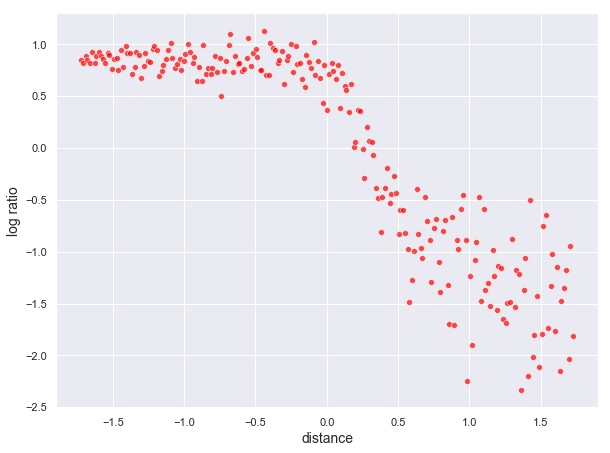

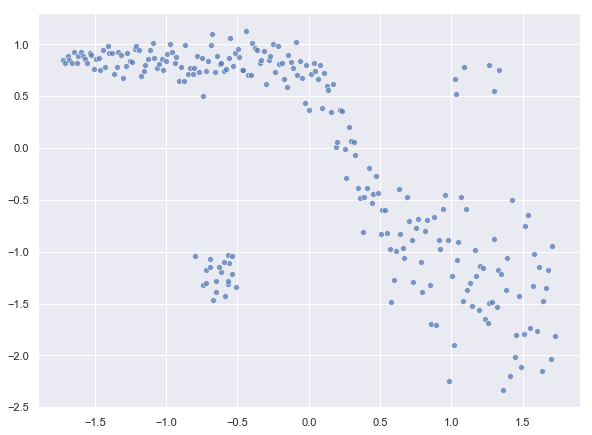

In [55]:
X = pd.read_csv('../dataset/lidar.tsv', sep='  ')
x_range = X['range']
y_ratio = X['logratio']

sns.set(rc={'figure.figsize':(9.7,7.27)})

x_range = np.array((x_range-np.mean(x_range))/np.std(x_range))
y_ratio = np.array((y_ratio-np.mean(y_ratio))/np.std(y_ratio))
sns.scatterplot(x_range, y_ratio, alpha=0.7, color='red')
plt.xlabel('distance', fontsize=14)
plt.ylabel('log ratio', fontsize=14)
plt.show()

x_out1 = np.random.uniform(low=-0.8, high=-0.5, size=(20,))
y_out1 = np.random.uniform(low=-1.5, high=-1, size=(20,))
x_out2 = np.random.uniform(low=1, high=1.5, size=(6,))
y_out2 = np.random.uniform(low=0.5, high=1, size=(6,))

x_range_out = np.concatenate((x_range,x_out1), axis=0)
x_range_out = np.concatenate((x_range_out,x_out2), axis=0)
y_ratio_out = np.concatenate((y_ratio,y_out1), axis=0)
y_ratio_out = np.concatenate((y_ratio_out,y_out2), axis=0)
sns.scatterplot(x_range_out, y_ratio_out, alpha=0.7)

# Heteroskedastic data: MOTOR

133


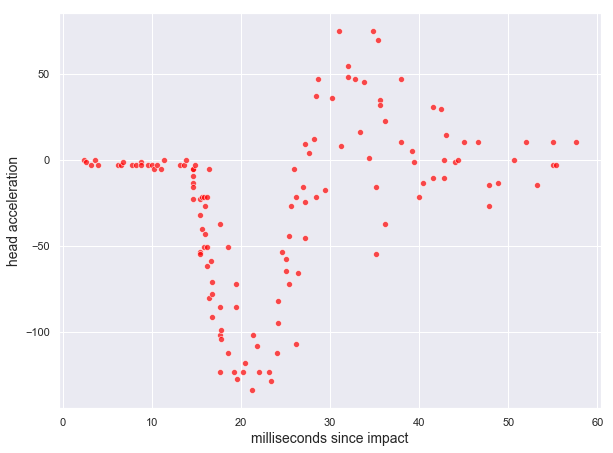

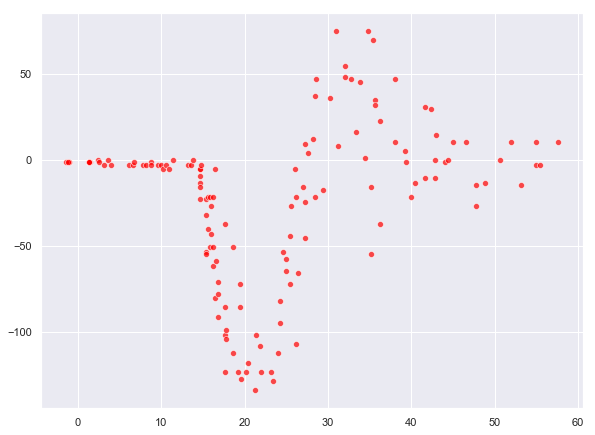

In [49]:
X = pd.read_csv('../dataset/mcycle.csv')
x_motor = X['times']
y_motor = X['accel']
x_motor = scaler(x_motor)
y_motor = scaler(y_motor)
print(len(x_motor))

x_out1 = np.random.uniform(low=-1.5, high=-1, size=(4,))
y_out1 = np.random.uniform(low=-1, high=-1.4, size=(4,))
x_out2 = np.random.uniform(low=1.3, high=1.5, size=(5,))
y_out2 = np.random.uniform(low=-1, high=-1.5, size=(5,))

x_motor_out = np.concatenate((x_motor,x_out1), axis=0)
x_motor_out = np.concatenate((x_motor_out,x_out2), axis=0)
y_motor_out = np.concatenate((y_motor,y_out1), axis=0)
y_motor_out = np.concatenate((y_motor_out,y_out2), axis=0)

sns.scatterplot(x_motor, y_motor, alpha=0.7, color ='red')
plt.xlabel('milliseconds since impact', fontsize=14)
plt.ylabel('head acceleration', fontsize=14)
plt.show()

sns.scatterplot(x_motor_out, y_motor_out, alpha=0.7, color='red')
plt.show()

In [66]:
dataset = 'motor'   #'motor'
outliers = False

if dataset=='lidar':
    #trXnoout, teXnoout, trYnoout, teYnoout = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
    #if outliers:
    #    x_range, y_ratio = x_range_out, y_ratio_out
    trX, teX, trY, teY = train_test_split(x_range, y_ratio, test_size=0.3, random_state=0)
    
elif dataset=='motor':
    #trXnoout, teXnoout, trYnoout, teYnoout = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)
    #if outliers:
    #    x_motor, y_motor = x_motor_out, y_motor_out
    trX, teX, trY, teY = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)

In [64]:
print(trX.shape, trY.shape)

(154,) (154,)


In [9]:
gaussian = Gaussian()
laplace = Laplace()
adaptive = Adaptive()

## Polynomial regression with regular, adaptive and locally adaptive

In [ ]:
x, y = torch.Tensor(trX), torch.Tensor(trY)
x_noout, y_noout = torch.Tensor(trXnoout), torch.Tensor(trYnoout)

# define regression degree
reg_degree = 5

# define regression model
lr = PolyRegression(reg_degree)

# regular loss training
reg_fit = train_regular(lr, x, y, gaussian, epoch=1000, learning_rate=1e-2, verbose=False)

# ada loss training
ada_fit, alpha, scale = train_adaptive(lr, x, y, learning_rate=0.01, epoch=500, verbose=False)

# adalocal loss training
alpha_model = PolyRegression(5, init_zeros=True)
scale_model = PolyRegression(5, init_zeros=True)
ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, x,y, learning_rate=0.01, epoch=500, verbose=False)

# 5-fold cross-validation for model degree

In [69]:
from sklearn.metrics import mean_absolute_error

x, y = torch.Tensor(trX), torch.Tensor(trY)
outliers = False

if dataset == 'lidar':
    x_out1 = np.random.uniform(low=-0.8, high=-0.5, size=(10,))
    y_out1 = np.random.uniform(low=-1.5, high=-1, size=(10,))
    x_out2 = np.random.uniform(low=1, high=1.5, size=(10,))
    y_out2 = np.random.uniform(low=0.5, high=1, size=(10,))
    
if dataset == 'motor':
    x_out1 = np.random.uniform(low=-1.5, high=-1, size=(10,))
    y_out1 = np.random.uniform(low=-1, high=-1.4, size=(10,))
    x_out2 = np.random.uniform(low=1.3, high=1.5, size=(10,))
    y_out2 = np.random.uniform(low=-1, high=-1.5, size=(10,))

n_splits = 5

cv = KFold(n_splits=n_splits, shuffle=True, random_state=3)

reg_degrees = 7

table = np.zeros((reg_degrees, 4))
tablemae = np.zeros((reg_degrees, 4))

for i in range(reg_degrees):
    
    reg_degree = i+1
   
    gauss_log_likelihoods = np.zeros((n_splits,1))
    laplace_log_likelihoods = np.zeros((n_splits,1))
    ada_log_likelihoods = np.zeros((n_splits,1))
    adaloc_log_likelihoods = np.zeros((n_splits,1))
    
    gauss_maes = np.zeros((n_splits,1))
    laplace_maes = np.zeros((n_splits,1))
    ada_maes = np.zeros((n_splits,1))
    adaloc_maes = np.zeros((n_splits,1))
    
    j = 0

    for train_index, test_index in cv.split(x):
            
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        if outliers:
            x_outs = np.concatenate([x_out1[j*2:j*2+2], x_out2[j*2:j*2+2]])
            y_outs = np.concatenate([y_out1[j*2:j*2+2], y_out2[j*2:j*2+2]])
            X_train = torch.cat((X_train, torch.Tensor(x_outs)))
            y_train = torch.cat((y_train, torch.Tensor(y_outs)))
            

        # define regression model
        lr = PolyRegression(reg_degree)

        # regular loss training - gaussian
        lr = PolyRegression(reg_degree)
        reg_fit = train_regular(lr, X_train, y_train, gaussian, epoch=500, learning_rate=0.01, verbose=False)
        
        # regular loss training - laplace
        lr = PolyRegression(reg_degree)
        reg_fit_laplace = train_regular(lr, X_train, y_train, laplace, epoch=500, learning_rate=0.01, verbose=False)

        # ada loss training
        lr = PolyRegression(reg_degree)
        ada_fit, alpha, scale = train_adaptive(lr, X_train, y_train, learning_rate=0.01, epoch=500, verbose=False)

        # adalocal loss training
        lr = PolyRegression(reg_degree)
        alpha_model = PolyRegression(2, init_zeros=True)
        scale_model = PolyRegression(2, init_zeros=True)
        ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, X_train, y_train, 
                                                                   learning_rate=0.01, epoch=500, verbose=False)
                

        sortedx, idxX = torch.sort(X_val)
        y2 = reg_fit(sortedx).detach().view(-1)
        ylap = reg_fit_laplace(sortedx).detach().view(-1)
        yar = ada_fit(sortedx).detach().view(-1)
        yalr = ada_loc_fit(sortedx).detach().view(-1)
        alphas = torch.exp(alpha_model(sortedx).view(-1))
        scales = torch.exp(scale_model(sortedx).view(-1))
        
        # test on non outliers 
        # include modal regression
        
        gauss_log_lik = gaussian.loglikelihood(y2.numpy().flatten()-y_val.numpy().flatten())
        laplace_log_lik = laplace.loglikelihood(ylap.numpy().flatten()-y_val.numpy().flatten())
        ada_log_lik = adaptive.loglikelihood(yar-y_val[idxX], alpha, scale)
        adaloc_log_lik = adaptive.loglikelihood(yalr-y_val[idxX], alphas, scales)
        
        gauss_mae = mean_absolute_error(y_val[idxX].numpy().flatten(), y2.numpy().flatten())
        laplace_mae = mean_absolute_error(y_val[idxX].numpy().flatten(), ylap.numpy().flatten())
        ada_mae = mean_absolute_error(y_val[idxX].numpy().flatten(), yar.numpy().flatten())
        adaloc_mae = mean_absolute_error(y_val[idxX].numpy().flatten(), yalr.numpy().flatten())
        
        gauss_log_likelihoods[j,:] = gauss_log_lik
        laplace_log_likelihoods[j,:] = laplace_log_lik
        ada_log_likelihoods[j,:] = ada_log_lik
        adaloc_log_likelihoods[j,:] = adaloc_log_lik
        
        gauss_maes[j,:] = gauss_mae
        laplace_maes[j,:] = laplace_mae
        ada_maes[j,:] = ada_mae
        adaloc_maes[j,:] = adaloc_mae

        print('Polynomial degree ', reg_degree)
        print('Gaussian Log Likelihood: ', gaussian.loglikelihood(y2.numpy().flatten()-y_val[idxX].numpy().flatten()))
        print('Laplace Log Likelihood: ', laplace.loglikelihood(ylap.numpy().flatten()-y_val[idxX].numpy().flatten()))
        print('Adaptive Log Likelihood: ', adaptive.loglikelihood(yar-y_val[idxX], alpha, scale))
        print('Ada+reg Log Likelihood : ', adaptive.loglikelihood(yalr-y_val[idxX], alphas, scales))
        
        sns.scatterplot(X_val, y_val, alpha=0.2)
        sns.lineplot(sortedx.detach().numpy(), y2.detach().numpy().flatten(), label='regular')
        sns.lineplot(sortedx.detach().numpy(), yar.detach().numpy().flatten(), label='adaptive robust 2d')
        sns.lineplot(sortedx.detach().numpy(), yalr.detach().numpy().flatten(), label='adaptive robust 2d + regression')
        plt.show()
        
        j += 1
    
    gauss_log_likelihood_mean = np.mean(gauss_log_likelihoods)
    laplace_log_likelihood_mean = np.mean(laplace_log_likelihoods)
    ada_log_likelihood_mean = np.mean(ada_log_likelihoods)
    adaloc_log_likelihood_mean = np.mean(adaloc_log_likelihoods)
    
    gauss_mae_mean = np.mean(gauss_maes)
    laplace_mae_mean = np.mean(laplace_maes)
    ada_mae_mean = np.mean(ada_maes)
    adaloc_mae_mean = np.mean(adaloc_maes)
    
    table[i, 0] = gauss_log_likelihood_mean
    table[i, 1] = laplace_log_likelihood_mean
    table[i, 2] = ada_log_likelihood_mean
    table[i, 3] = adaloc_log_likelihood_mean
    
    tablemae[i, 0] = gauss_mae_mean
    tablemae[i, 1] = laplace_mae_mean
    tablemae[i, 2] = ada_mae_mean
    tablemae[i, 3] = adaloc_mae_mean
    
    
    

  0%|                                                  | 0/500 [00:00<?, ?it/s]


AssertionError: 

In [12]:
#np.set_printoptions(suppress=True,
#   formatter={'float_kind':'{:f}'.format})

np.savetxt('motor_loglike.csv', np.round(table, 2), delimiter = ',')

print(np.round(table, 2))

np.savetxt('motor_mae.csv', np.round(tablemae, 2), delimiter = ',')

print(np.round(tablemae, 2))

[[-2.71700000e+01 -2.76200000e+01 -2.65200000e+01 -3.74936331e+06]
 [-2.76700000e+01 -2.72400000e+01 -2.64500000e+01 -2.60800000e+01]
 [-2.94000000e+01 -2.93600000e+01 -2.41600000e+01 -2.11500000e+01]
 [-2.92200000e+01 -2.88400000e+01 -2.43300000e+01 -2.51000000e+01]
 [-2.90400000e+01 -2.98000000e+01 -2.25200000e+01 -2.27500000e+01]
 [-2.87900000e+01 -2.94400000e+01 -2.59000000e+01 -2.17300000e+01]
 [-2.87800000e+01 -3.02800000e+01 -2.62800000e+01 -2.16800000e+01]]
[[0.79 0.8  0.79 0.81]
 [0.76 0.72 0.77 0.76]
 [0.71 0.73 0.71 0.76]
 [0.71 0.73 0.71 0.79]
 [0.67 0.64 0.64 0.66]
 [0.76 0.65 0.76 0.65]
 [0.69 0.68 0.8  0.68]]


In [29]:
# best model performance on test set

outliers = False

if dataset == 'motor':
    x_out1 = np.random.uniform(low=-1.5, high=-1, size=(10,))
    y_out1 = np.random.uniform(low=-1, high=-1.4, size=(10,))
    x_out2 = np.random.uniform(low=1.3, high=1.5, size=(10,))
    y_out2 = np.random.uniform(low=-1, high=-1.5, size=(10,))

#trX, teX, trY, teY = train_test_split(x_motor, y_motor, test_size=0.3, random_state=0)

trX, trY = torch.Tensor(trX), torch.Tensor(trY)
teX, teY = torch.Tensor(teX), torch.Tensor(teY)

if outliers:
    x_outs = np.concatenate([x_out1[j*2:j*2+2], x_out2[j*2:j*2+2]])
    y_outs = np.concatenate([y_out1[j*2:j*2+2], y_out2[j*2:j*2+2]])
    trX = torch.cat((trX, torch.Tensor(x_outs)))
    trY = torch.cat((trY, torch.Tensor(y_outs)))

print(teX.shape)
print(teY.shape)

reg_degree = 3

lr = PolyRegression(reg_degree)

# regular loss training - gaussian
lr = PolyRegression(reg_degree)
reg_fit = train_regular(lr, trX, trY, gaussian, epoch=500, learning_rate=0.01, verbose=False)

# regular loss training - laplace
lr = PolyRegression(reg_degree)
reg_fit_laplace = train_regular(lr, trX, trY, laplace, epoch=500, learning_rate=0.01, verbose=False)

# ada loss training
lr = PolyRegression(reg_degree)
ada_fit, alpha, scale = train_adaptive(lr, trX, trY, learning_rate=0.01, epoch=500, verbose=False)

# adalocal loss training
lr = PolyRegression(reg_degree)
alpha_model = PolyRegression(2, init_zeros=True)
scale_model = PolyRegression(2, init_zeros=True)
ada_loc_fit, alpha_loc, scale_loc = train_locally_adaptive(lr, alpha_model, scale_model, trX, trY, 
                                                           learning_rate=0.01, epoch=500, verbose=False)

y2_test = reg_fit(teX).detach().view(-1)
ylap_test = reg_fit_laplace(teX).detach().view(-1)
yar_test = ada_fit(teX).detach().view(-1)
yalr_test = ada_loc_fit(teX).detach().view(-1)
alphas = torch.exp(alpha_model(teX).view(-1))
scales = torch.exp(scale_model(teX).view(-1))

gauss_log_lik = gaussian.loglikelihood(y2_test.numpy().flatten()-teY.numpy().flatten())
laplace_log_lik = laplace.loglikelihood(ylap_test.numpy().flatten()-teY.numpy().flatten())
ada_log_lik = adaptive.loglikelihood(yar_test-teY, alpha, scale)
adaloc_log_lik = adaptive.loglikelihood(yalr_test-teY, alphas, scales)

gauss_mae = mean_absolute_error(teY.numpy().flatten(), y2_test.numpy().flatten())
laplace_mae = mean_absolute_error(teY.numpy().flatten(), ylap_test.numpy().flatten())
ada_mae = mean_absolute_error(teY.numpy().flatten(), yar_test.numpy().flatten())
adaloc_mae = mean_absolute_error(teY.numpy().flatten(), yalr_test.numpy().flatten())

print('log likelihoods')
print(gauss_log_lik)
print(laplace_log_lik)
print(ada_log_lik)
print(adaloc_log_lik)
print('MAEs')
print(gauss_mae)
print(laplace_mae)
print(ada_mae)
print(adaloc_mae)

ml = ModalLinearRegression(kernel="gaussian", poly=2, bandwidth=1)
ml.fit(trX.numpy().reshape(-1,1), trY.numpy().reshape(-1,1))
print(teX.shape)
yml = ml.predict(teX.numpy().reshape(-1,1))
print(yml.shape)
print('modal', mean_absolute_error(teX.numpy().reshape(-1,1), yml.flatten()))

torch.Size([40])
torch.Size([40])


100%|███████████████████████████████████████| 500/500 [00:02<00:00, 226.86it/s]


log likelihoods
-45.93660818149644
-50.53508321933104
-46.17439
-38.913536
MAEs
0.640759
0.6461018
0.64297706
0.7502042
Fit with the EM algorithm


100%|██████████████████████████████████████| 100/100 [00:00<00:00, 2702.71it/s]


torch.Size([40])
(2, 1) (1,)


ValueError: all the input arrays must have same number of dimensions

In [ ]:
for i in range(table.shape[0]):
    plt.bar([0,1,2,3], table[i,:])
    plt.show()

# GP baseline

In [14]:
# GP regression
xGP, yGP = torch.Tensor(trX), torch.Tensor(trY)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(xGP, yGP, likelihood)

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 50
for i in tqdm(range(training_iter)):
    optimizer.zero_grad()
    output = model(xGP)
    loss = -mll(output, yGP)
    loss.backward()
    optimizer.step()
    


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 141.24it/s]


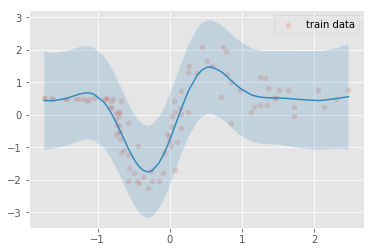

In [15]:
sortedx, idxX = torch.sort(xGP)
sortedy = y[idxX]

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(sortedx))
    lower, upper = observed_pred.confidence_region()
    sns.scatterplot(trX, trY, label='train data', alpha=0.2)
    sns.lineplot(sortedx, observed_pred.mean.numpy(), color=palette[1])
    plt.fill_between(sortedx.detach(), lower.numpy(), upper.numpy(), alpha=0.2)

In [16]:
mll(observed_pred, teY)*len(teY)

RuntimeError: The size of tensor a (40) must match the size of tensor b (93) at non-singleton dimension 0